In [1]:
import os
import re 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle 
from itertools import combinations
from model.utils import make_logInfo, save_csv, PRF1
os.chdir('/home/wzy/Documents/porject/gene_dis_predict_by_ML')

In [4]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 15,
}
figureSize=(8,6)
fileType='png'

## OpenNE评价绘图

In [196]:
openneLog = open('result/openneLog_64.txt','r').read()

# method = ['DeepWalk', 'LINE', 'Node2vec', 'HOPE', 'SDNE']
method = ['DeepWalk', 'LINE', 'Node2vec', 'GraRep','HOPE', 'SDNE']
result = re.compile('\n\{.*?\}\n').findall(openneLog)
result = list(map(eval,map(str.strip,result))) # 将字符串转换为字典，并且去除周围的空白字符

neDF = pd.DataFrame(result)
neDF['method'] = method
neDF

,micro,macro,samples,weighted,method
0,0.882413,0.803117,0.882413,0.875694,DeepWalk
1,0.929500,0.882085,0.929500,0.927037,LINE
2,0.892577,0.815396,0.892577,0.886050,Node2vec
3,0.792873,0.442236,0.792873,0.701274,GraRep
4,0.915734,0.847945,0.915734,0.908537,HOPE
5,0.918950,0.852604,0.918950,0.911978,SDNE


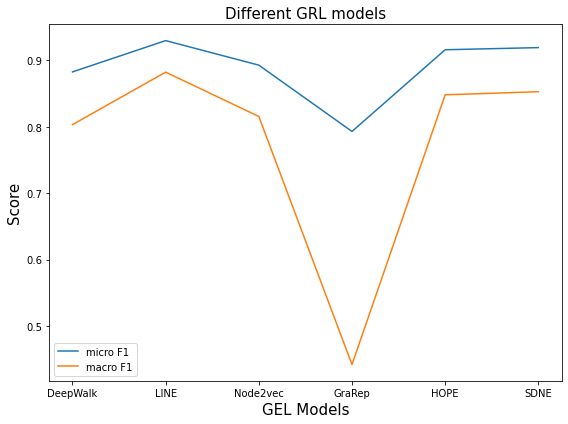

In [305]:
plt.figure(figsize=figureSize)
sns.lineplot(data=neDF,x='method',y='micro',label='micro F1')
sns.lineplot(data=neDF,x='method',y='macro',label='macro F1')
# sns.lineplot(data=neDF,x='method',y='samples',label='samples')
# sns.lineplot(data=neDF,x='method',y='weighted',label='weighted')
plt.ylabel('Score',font1)
plt.xlabel('GEL Models',font1)
plt.title('Different GRL models',font1)
plt.savefig('result/figures/best_openNE.{}'.format(fileType),dpi=400)

根据上图的结果，选择`LINE`, `HOPE`, `SDNE`, 作为备选的Embedding方法，进行排列组合选择最佳的嵌入组合。

并且选择`LINE`作为基本嵌入算法，用于比较不同机器学习模型的差异

### 最佳模型组合的评价

将多个结果结果拼接起来，选择最好的OpenNE和ML模型的组合

In [ ]:
openNEModel = ['LINE', 'SDNE', 'HOPE']
openNEComb = list(combinations(openNEModel, 1))+list(combinations(openNEModel, 2))+list(combinations(openNEModel, 3))
findResult = pd.DataFrame()
for methodCmb in openNEComb:
    ms = '_'.join(methodCmb)
    df = pd.read_csv('log/07-10/13_result_{}.csv'.format(ms))
    df['method'] = ms
    findResult = pd.concat([findResult,df],axis=0)

In [ ]:
# 用于填写ablation中的GRL Models 和 ML Models
r = findResult.groupby(['model','method']).agg(['mean','std']).reset_index()
for s in ['A', 'P(PPV)', 'R(Sen)(TPR)', 'Spec(TNR)', 'F1', 'AUC', 'AUPR']:
    r[s] = r.loc[:,s]['mean'].round(3).astype(str) + '±' + r.loc[:,s]['std'].round(3).astype(str)
r.to_csv('result/metrics/ablation_study_ML.csv',index=False)

In [ ]:
findResultGB = findResult.groupby(['model','method']).mean().reset_index()
findResultGB.to_csv('result/metrics/find_best.csv',index=False)

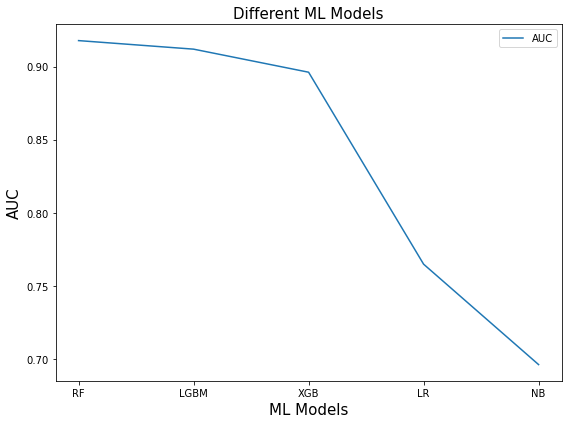

In [473]:
mlR=pd.read_csv('log/07-24/23_Find_ML_PRF1_0.csv').groupby('model').mean().reset_index().sort_values('AUC',ascending=False)
plt.figure(figsize=figureSize)
sns.lineplot(data=mlR,x='model',y='AUC',label='AUC')
plt.xlabel('ML Models',font1) 
plt.ylabel('AUC',font1)
plt.title('Different ML Models',font1)
plt.savefig('result/figures/best_ML_models_of_5.{}'.format(fileType),dpi=400)

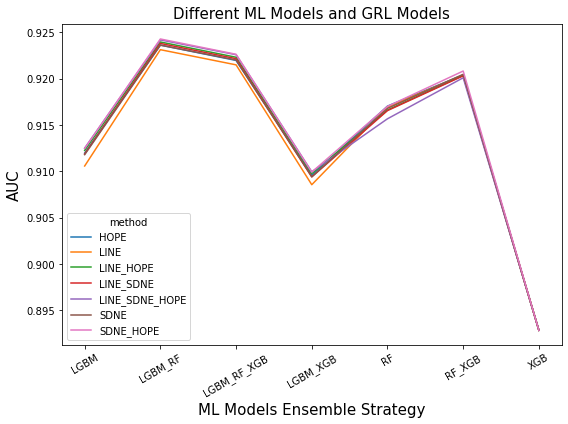

In [308]:
plt.figure(figsize=figureSize)

sns.lineplot(data=findResultGB,x='model',y='AUC',hue='method')

plt.xticks(rotation=30)
plt.xlabel('ML Models Ensemble Strategy',font1) 
plt.ylabel('AUC',font1)
plt.title('Different ML Models and GRL Models',font1)
plt.savefig('result/figures/best_ML_models.{}'.format(fileType),dpi=400)


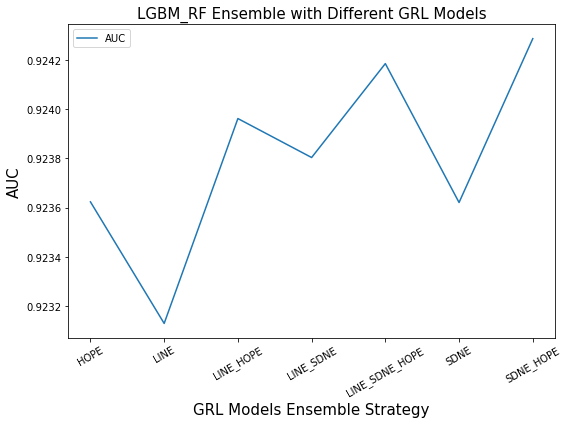

In [309]:
plt.figure(figsize=figureSize)
sns.lineplot(data=findResultGB[findResultGB.model=='LGBM_RF'],x='method',y='AUC',label='AUC')
# sns.lineplot(data=findResult[findResult.model=='LGBM_RF'],x='method',y='AUPR',label='AUPR')
plt.xticks(rotation=30)
plt.xlabel('GRL Models Ensemble Strategy',font1) 
plt.ylabel('AUC',font1)
plt.title('LGBM_RF Ensemble with Different GRL Models',font1)
plt.savefig('result/figures/best_GRL_models.{}'.format(fileType),dpi=400)

In [ ]:
# plt.figure(figsize=figureSize)
# sns.lineplot(data=findResult,x='method',y='AUC',hue='model')
# plt.xticks(rotation=30)
# plt.xlabel('GRL Models',font1) 
# plt.ylabel('AUC',font1)
# plt.title('Different ML models and GRL models',font1)
# # plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), ncol=4)
# plt.savefig('result/figures/best_ML_all_models.pdf',dpi=400)

# plt.figure(figsize=figureSize)
# sns.lineplot(data=r,x='method',y='AUC',label='AUC')
# plt.xlabel('ML Models',font1) 
# plt.ylabel('AUC',font1)
# plt.title('Different ML Models',font1)
# plt.savefig('result/figures/best_ML_models_of_5.{}'.format(fileType),dpi=400)

## LUPI_RGCN kfold 结果评价

In [6]:
prf1List=[]
for seed in range(10):
    presuffix = 'result_LUPI_RGCN/07-10/{}'.format(seed)
    folds = ['{}result_fold{}.pickle'.format(presuffix,i+1) for i in range(5)]

    resultDF = pd.DataFrame()
    for i,fold in enumerate(folds): # 读取每一个fold的结果，并将结果保存resultDF中
        with open(fold,'rb') as f:
            r = pickle.load(f)
            r['trainLoss'] = list(map(lambda x:float(x.detach()),r['trainLoss']))
            
            r['fold'] = [i+1]*len(r['trainLoss'])
            r['seed'] = [seed]*len(r['trainLoss'])
        resultDF = pd.concat([resultDF,pd.DataFrame(r)],axis=0)
        
    # 合并fold值
    YTEST = [];YPROB=[]
    for idx,item in (resultDF[resultDF.epochs==700]).iterrows(): # 选择最后一个epoch的结果的测试集和验证集合并，计算每个fold计算macro评价指标
        # print(item['ytest'].shape,item['yproba'].shape)
        YTEST.extend(list(item['ytest']))
        YPROB.extend(list(item['yproba']))
    # print('seed {}: '.format(seed),len(YTEST),len(YPROB))
    pd.DataFrame([YPROB,YTEST]).T.rename({0:'yprob',1:'ytest'},axis=1).to_csv(
        'result/seedResult/LUPI_RGCN_result/LUPI_RGCN_predictions_ratio1_{}.csv'.format(seed),index=False)
    prf1 = PRF1(np.array(YTEST),np.array(YPROB))
    prf1['seed']=seed
    prf1List.append(prf1)

calResult = pd.DataFrame(prf1List)
calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
calResult.to_csv('result/metrics/LUPI_RGCN_predictions_ratio1.csv')

## ML kfold 结果评价

### 随机种子评价

将10个随机种子的5个fold的验证集拼接起来，计算宏观评价指标。

**在运行随机种子的时候，将hour变量设置为args.seed，这样在保存文件的时候会以seed作为前缀进行命名，方便后续对随机种子进行分析**

In [4]:
# 在不同比例中计算macro评价指标
for ratio in [1,3,5,10,20]:
    prf1List=[]
    for seed in range(10):
        presuffix = 'log/ML/seed{}'.format(seed)
        folds = ['{}_fold{}_sam20.csv'.format(presuffix,i+1) for i in range(5)]

        resultDF = pd.DataFrame()
        for i,fold in enumerate(folds): # 读取每一个fold的结果，并将结果保存resultDF中
            r = pd.read_csv(fold)
            resultDF = pd.concat([resultDF,pd.DataFrame(r)],axis=0)
        
        ratioDF = resultDF[resultDF.sam==ratio]
        YTEST = ratioDF.ytest.values; YPROB=ratioDF.yprob.values
        # print('seed {}\tratio {}: '.format(seed,ratio),len(YTEST),len(YPROB))

        pd.DataFrame([YPROB,YTEST]).T.rename({0:'yprob',1:'ytest'},axis=1).to_csv(
            'result/seedResult/ML_result/ML_predictions_ratio{}_{}.csv'.format(ratio,seed),index=False)
        prf1 = PRF1(np.array(YTEST),np.array(YPROB))
        prf1['seed']=seed
        prf1['ratio']=ratio
        prf1List.append(prf1)
    calResult = pd.DataFrame(prf1List)
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/ML_predictions_ratio{}.csv'.format(ratio))

# findNew result


dis & gene

In [179]:
for tp in ['dis','gene']:
    prf1List=[]
    for seed in range(10):
        r=pd.read_csv('log/uk_gd/{}_ML_prediction_findNew_{}.csv'.format(seed,tp))
        YTEST = r['YTEST']; YPROB=r['YPROB']
        if seed==0:
            pd.DataFrame([YPROB,YTEST]).T.rename({0:'yprob',1:'ytest'},axis=1).to_csv(
                    'result/uk_gd/ML_predictions_uk{}_{}.csv'.format(tp[0].upper()+tp[1:],seed),index=False)
        prf1 = PRF1(np.array(YTEST),np.array(YPROB))
        prf1['seed']=seed
        prf1List.append(prf1)
    calResult = pd.DataFrame(prf1List)
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/ML_predictions_uk{}.csv'.format(tp[0].upper()+tp[1:]))

LUPI_RGCN

In [180]:
for tp in ['Dis','Gene']:
    prf1List=[]
    for seed in range(10):
        r=pd.read_csv('result_LUPI_RGCN/uk_gd/LUPI_RGCN_uk{}_{}.csv'.format(tp,seed),index_col=0)
        YTEST = r['ytest']; YPROB=r['yprob']
        if seed==0:
            pd.DataFrame([YPROB,YTEST]).T.rename({0:'yprob',1:'ytest'},axis=1).to_csv(
                    'result/uk_gd/LUPI_RGCN_predictions_uk{}_{}.csv'.format(tp,seed),index=False)
        prf1 = PRF1(np.array(YTEST),np.array(YPROB))
        prf1['seed']=seed
        prf1List.append(prf1)
    calResult = pd.DataFrame(prf1List)
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/LUPI_RGCN_predictions_uk{}.csv'.format(tp))

# ROC & PR Curve

两套配色方案：
```python
model = {'HAN':{'name':'HAN','color':'tab:orange'},
         'HGT':{'name':'HGT','color':'tab:red'},
         'PGCN':{'name':'PGCN','color':'tab:green'},
         'RGCN':{'name':'RGCN','color':'tab:pink'},
         'LUPI_RGCN':{'name':'LUPI_RGCN','color':'tab:brown'},
         'ML':{'name':'MGREL','color':'tab:blue'}}
```

```python
model = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
        #  'LUPI_RGCN':{'name':'LUPI_RGCN','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}
```


In [468]:
model = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
         'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}

In [469]:
def plot_ROC_kmodel_line(ytestList:list,yprobList:list,label:list,suffix:str='',
                         titleStr:str='ROC',fileType:str='pdf',figureSize:tuple=(8,6)):
    from sklearn.metrics import roc_curve
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=figureSize)
    for ytest,yprob,l in zip(ytestList,yprobList,label):
        # print(l)
        fpr, tpr, _ = roc_curve(ytest, yprob)
        tpr = np.interp(mean_fpr, fpr, tpr)
        tpr[0] = 0.0
        plt.plot(mean_fpr, tpr, lw=1.4, label=l['name_AUC'],color=l['color'])

    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))#, label='Luck')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate',font1)
    plt.ylabel('True Positive Rate',font1)
    plt.title(titleStr,font1)
    plt.legend(loc="lower right")
    if suffix!='':
        plt.savefig('result/figures/roc_{}.{}'.format(suffix,fileType),dpi=400)
        print('file has been saved in: result/figures/roc_{}.{}'.format(suffix,fileType))
    plt.close()

def plot_AUPR_kmodel_line(ytestList:list,yprobList:list,label:list,suffix:str='',
                          titleStr:str='Precision-Recall Curve',fileType:str='pdf',figureSize:tuple=(8,6)):
    from sklearn.metrics import precision_recall_curve
    plt.figure(figsize=figureSize)
    mean_fpr = np.linspace(0, 1, 100)
    for ytest,yprob,l in zip(ytestList,yprobList,label):
        # print(l)
        precision, recall, _ = precision_recall_curve(ytest, yprob)
        precision = np.interp(mean_fpr, precision, recall)
        precision[0] = 1
        plt.plot(mean_fpr, precision, lw=1.4, label=l['name_AUPR'],color=l['color'])
    
    # font1 = {'family' : 'Times New Roman',
    # 'weight' : 'normal',
    # 'size'   : 13,
    # }
    plt.plot([1, 0], [0, 1], '--', color=(0.6, 0.6, 0.6))#, label='Luck')
    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('Recall',font1)
    plt.ylabel('Precision',font1)
    plt.title(titleStr,font1)
    plt.legend(loc="lower left")
    if suffix!='':
        plt.savefig('result/figures/auproc_{}.{}'.format(suffix,fileType),dpi=400)
        print('file has been saved in: result/figures/auproc_{}.{}'.format(suffix,fileType))
    plt.close()

## ratio 分析

1. 首先是1：1的模型比较图，LUPI_RGCN只参与1：1分析，以result中的ratio1_0为数据源绘制
1. 大表的可视化绘制，bar图以及在bar上加分割线（LUPI_RGCN不参与此分析），以metrics中的数值数据源进行绘图即可

ratio:1

In [470]:
ytestList=[];yprobList=[];label=[]
model = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
         'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}
for k,v in model.items():
    # print(k)
    r = pd.read_csv('result/seedResult/{}_result/{}_predictions_ratio1_0.csv'.format(k,k))
    ytest = r.iloc[:,1]; yprob = r.iloc[:,0]
    ytestList.append(ytest.values)
    yprobList.append(yprob.values)
    prf1=PRF1(ytest,yprob)
    v['name_AUC']='{}:{:.3f}'.format(v['name'],prf1['AUC'])
    v['name_AUPR']='{}:{:.3f}'.format(v['name'],prf1['AUPR'])
    label.append(v)
plot_ROC_kmodel_line(ytestList,yprobList,label,titleStr='Receiver Operating Characteristic Curve of Models',suffix='ratio1',fileType=fileType)
plt.close()
plot_AUPR_kmodel_line(ytestList,yprobList,label,titleStr='Precision-Recall Curve of Models',suffix='ratio1',fileType=fileType)    

file has been saved in: result/figures/roc_ratio1.png
file has been saved in: result/figures/auproc_ratio1.png


展示ratio的条形图。因为不需要绘制ROC，所以可以直接利用计算好的metrics。以model为横轴

In [274]:
ytestList=[];yprobList=[];label=[]

model2 = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
        #  'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}
         
resultDF = pd.DataFrame()
for k,v in model2.items():
    # print(k)
    for ratio in [3,5,10,20]:
        try:
            r = pd.read_csv('result/metrics/{}_predictions_ratio{}.csv'.format(k,ratio))
            r.rename(columns={'Unnamed: 0':'idx','F1':'F1-Score','A':'Accuracy','R(Sen)(TPR)':'Recall','Spec(TNR)':'Specificity','P(PPV)':'Precision'},inplace=True)
        except Exception as e:
            print(e)
            continue
        r['ratio'] = ratio
        r['model'] = k
        resultDF = pd.concat([resultDF,r],axis=0)

# plt.rcParams.update({'figure.autolayout': True})
metricsList = ['AUC','AUPR','F1-Score','Accuracy','Recall','Specificity','Precision']
metricsList = metricsList[:3]
c=['#FF6B6B','#F9D923','#36AE7C','#187498']
for metrics in metricsList:
    plt.figure(figsize=figureSize)
    x=np.arange(len(model2))
    x*=2; width = 0.4
    fig,ax = plt.subplots()
    error_attri={'elinewidth':0.8,'ecolor':'black','capsize':4}
    r=resultDF[resultDF.idx.isin(['Avg','Std'])]
    for i,ratio in enumerate([3,5,10,20]):
        rAvg = r[(r.ratio==ratio) &(r.idx=='Avg')][metrics].astype(float).tolist()
        rStd = r[(r.ratio==ratio) &(r.idx=='Std')][metrics].astype(float).tolist()
        # print(ratio,rAvg)
        ax.bar(x+i*width,rAvg,width,align='center',yerr=rStd,error_kw=error_attri,
               label='ratio={}'.format(ratio),color=c[i])#color=pd.DataFrame(model.values()).color.tolist()[i+1])

    #设置图像的一些参数
    ax.set_ylabel(metrics,font1)
    ax.set_xticks(x+3*width/2)
    ax.set_xticklabels(pd.DataFrame(model2.values()).name.tolist())
    # ax.set_yticks(list(np.linspace(0.,1.,5)))
    ax.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center',ncol=4)

    ax.set_title('Different Ratio of {}'.format(metrics),font1)
    # ax.set_xlabel(metrics,font1)

    plt.savefig('result/figures/ratio_{}.{}'.format(metrics,fileType),dpi=400)
    print('file has been saved in: result/figures/ratio_{}.{}'.format(metrics,fileType))
    plt.close()

file has been saved in: result/figures/ratio_AUC.pdf
file has been saved in: result/figures/ratio_AUPR.pdf
file has been saved in: result/figures/ratio_F1-Score.pdf


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

展示ratio的条形图。因为不需要绘制ROC，所以可以直接利用计算好的metrics
以ratio为横轴

In [286]:
ytestList=[];yprobList=[];label=[]
model2 = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
        #  'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}

resultDF = pd.DataFrame()
for k,v in model2.items():
    # print(k)
    for ratio in [3,5,10,20]:
        try:
            r = pd.read_csv('result/metrics/{}_predictions_ratio{}.csv'.format(k,ratio))
            r.rename(columns={'Unnamed: 0':'idx','F1':'F1-Score','A':'Accuracy','R(Sen)(TPR)':'Recall','Spec(TNR)':'Specificity','P(PPV)':'Precision'},inplace=True)
        except Exception as e:
            print(e)
            continue
        r['ratio'] = ratio
        r['model'] = k
        resultDF = pd.concat([resultDF,r],axis=0)

# plt.rcParams.update({'figure.autolayout': True})
metricsList = ['AUC','AUPR','F1-Score','Accuracy','Recall','Specificity','Precision']
metricsList = metricsList[:3]
c=['#ABC9FF','#FFDEDE','#FF8B8B','#EB4747']
for metrics in metricsList:
    plt.figure(figsize=figureSize)
    x=np.arange(len(['ratio={}'.format(i) for i in [3,5,10,20]])).astype(float)
    x*=2.5; width = 0.4
    fig,ax = plt.subplots(figsize = figureSize)
    error_attri={'elinewidth':0.8,'ecolor':'#2C272E','capsize':0.8}
    r=resultDF[resultDF.idx.isin(['Avg','Std'])]
    for i,(k,v) in enumerate(model2.items()):
        m=k
        # print(m,type(m))
        rAvg = r[(r.model==m) & (r.idx=='Avg')][metrics].astype(float).tolist()
        rStd = r[(r.model==m) & (r.idx=='Std')][metrics].astype(float).tolist()
        # print(ratio,rAvg)
        ax.bar(x+i*width,rAvg,width,align='center',yerr=rStd,error_kw=error_attri,
               label=v['name'],color=v['color'])#color=pd.DataFrame(model.values()).color.tolist()[i+1])

    #设置图像的一些参数
    ax.set_ylabel(metrics,font1)
    ax.set_xticks(x+3*width/2)
    ax.set_xticklabels(['ratio={}'.format(i) for i in [3,5,10,20]])
    # ax.set_yticks(list(np.linspace(0.,1.,5)))
    ax.legend(bbox_to_anchor=(0.5, -0.2),loc='lower center',ncol=5)

    ax.set_title('Different Ratio of {}'.format(metrics),font1)

    plt.savefig('result/figures/ratio_{}.{}'.format(metrics,fileType),dpi=400)
    print('file has been saved in: result/figures/ratio_{}.{}'.format(metrics,fileType))
    plt.close()

file has been saved in: result/figures/ratio_AUC.png
file has been saved in: result/figures/ratio_AUPR.png
file has been saved in: result/figures/ratio_F1-Score.png


<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

# findNew 

ROC & AUPROC

在运行完LUPI_RGCN之后需要重新绘制

In [471]:
tpDict={'Dis':'Disease', 'Gene':'Gene'}
for tp,n in tpDict.items():
    ytestList=[];yprobList=[];label=[]
    model = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
         'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}
    for k,v in model.items():
        r=pd.read_csv('result/uk_gd/{}_predictions_uk{}_0.csv'.format(k,tp))
        ytest = r.iloc[:,1]; yprob = r.iloc[:,0]
        ytestList.append(ytest.values)
        yprobList.append(yprob.values)
        prf1=PRF1(ytest,yprob)
        # label.append('ML:{}±{}'.format(prf1['AUC'],r['Std'][0]))
        v['name_AUC']='{}:{:.3f}'.format(v['name'],prf1['AUC'])
        v['name_AUPR']='{}:{:.3f}'.format(v['name'],prf1['AUPR'])
        label.append(v)
    plot_ROC_kmodel_line(ytestList,yprobList,label,titleStr='ROC of Unknown {} Prediction'.format(n),suffix='uk{}'.format(n),fileType=fileType)
    plt.close()
    plot_AUPR_kmodel_line(ytestList,yprobList,label,titleStr='Precision-Recall Curve of Unknown {} Prediction'.format(n),suffix='uk{}'.format(n),fileType=fileType)

file has been saved in: result/figures/roc_ukDisease.png
file has been saved in: result/figures/auproc_ukDisease.png
file has been saved in: result/figures/roc_ukGene.png
file has been saved in: result/figures/auproc_ukGene.png


# 消融实验分析

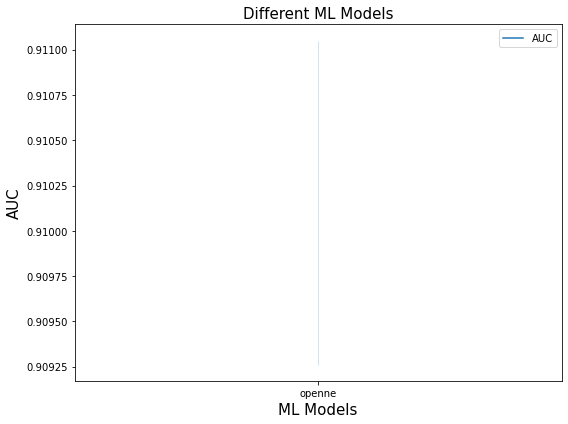

In [472]:
ablationDict={'ae':'AutoEncoder Features','openne':'MGRL Features'}
resultDF = pd.DataFrame()
for ablation,v in ablationDict.items():
    r = pd.read_csv('log/07-25/00_ablation_{}_0.csv'.format(ablation))
    r['method']=ablation
    calResult = r[r.method==ablation]
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/ablation_{}.csv'.format(ablation))

# 敏感性分析

In [5]:
def my_lineplot(data,x,y,label,markers,color,):
    dataGB = data.groupby(x)
    # 根据x的均值聚合，绘制点线
    plt.plot(dataGB.mean().index.tolist(),dataGB.mean()[y],label=label,marker=markers,color=color)
    # 根据y的std绘制阴影线
    plt.fill_between(dataGB.mean().index,dataGB.mean()[y]+dataGB.std()[y],dataGB.mean()[y]-dataGB.std()[y],color=color,alpha=0.2)

In [6]:
rc = pd.DataFrame()
for aeDim in [32,64,128,256]:
    r = pd.read_csv('log/sen/14_senPRF1_128_[512, {}]_0.csv'.format(aeDim))
    r['aeDim']=aeDim
    rc = rc.append(r)
    calResult = r[r.aeDim==aeDim]
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/sen_op_128_ae_{}.csv'.format(aeDim))

plt.figure(figsize=figureSize)
my_lineplot(data=rc,x='aeDim',y='AUPR',label='AUPR',markers='o',color='#EC5858')
my_lineplot(data=rc,x='aeDim',y='AUC',label='AUC',markers='o',color='#93ABD3')

plt.xticks([32,64,128,256])
plt.ylabel('Score',font1)
plt.xlabel('The Feature Dimension in AutoEncoder',font1)
# plt.title('Different Dimention of AutoEncoder',font1)
plt.legend()
plt.savefig('result/figures/sen_ae.{}'.format(fileType),dpi=400)
plt.close()

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


In [8]:
rc = pd.DataFrame()
for openneDim in [32,64,128,256]:
    r = pd.read_csv('log/sen/13_senPRF1_{}_[512, 64]_0.csv'.format(openneDim))
    r['openneDim']=openneDim
    rc = rc.append(r)
    calResult = r[r.openneDim==openneDim]
    calResult = calResult.append(pd.Series(calResult.mean(axis=0),name='Avg'))
    calResult = calResult.append(pd.Series(calResult.std(axis=0),name='Std'))
    calResult.at['Overall',:] = np.array(['{:.3f}±{:.3f}'.format(x,y) for x,y in zip(calResult.loc['Avg',:],calResult.loc['Std',:])])
    calResult.to_csv('result/metrics/sen_op{}_ae_64.csv'.format(openneDim))

plt.figure(figsize=figureSize)
my_lineplot(data=rc,x='openneDim',y='AUPR',label='AUPR',markers='o',color='#EC5858')
my_lineplot(data=rc,x='openneDim',y='AUC',label='AUC',markers='o',color='#93ABD3')
plt.xticks([32,64,128,256])
plt.ylabel('Score',font1)
plt.xlabel('The Feature Dimension in GRL',font1)
# plt.title('Different Dimention of MGRL',font1)
plt.legend(loc='best')
plt.savefig('result/figures/sen_mgrl.{}'.format(fileType),dpi=400)
plt.close()

# 案例分析


In [351]:
def find_optimal_cutoff(TPR:np.array, FPR:np.array, threshold:np.array):
    '''
    description: 获取最佳阈值点,并返回阈值和点的位置, 
                 一般被各种机器学习模型的kfold()函数调用,
                 用于为 wzyFunc.machineLearning.plot_ROC_kfold() 函数创建opts参数
    param {np} TPR: <- sklearn.metrics.roc_curve(ytest, yprob)
    param {np} FPR: <- sklearn.metrics.roc_curve(ytest, yprob)
    param {np} threshold: <- sklearn.metrics.roc_curve(ytest, yprob)
    return  optimal_threshold: int
            point: 点的坐标, 用于wzyFunc.machineLearning.plot_ROC_kfold()绘制
    '''
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

def PRF1(ytest:np.array, yprob:np.array,threshold:float=None)->dict:
    '''
    description: 警告: 如果两个模型不能输出prob和decision_function的话, 
                 模型无法计算AUC分数, 同时计算之后也没有任何意义! 
    param {np} ytest: 真实标签
    param {np} ypre: 模型预测标签
    param {np} yprob: 模型输出的每个样本的预测概率
    param {int} threshold: 阈值, 默认为0.5
    return prf1Dict: {'A','P(PPV)','R(Sen)(TPR)','Spec(TNR)','F1','AUC','AUPR','YI','threshold'}
    '''
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
        roc_auc_score, average_precision_score, confusion_matrix as CM,roc_curve
    cm={}   
    if threshold == None:
        fpr, tpr, thr = roc_curve(ytest, yprob)
        threshold, _ = find_optimal_cutoff(tpr, fpr, threshold=thr)
    ypre = (yprob>threshold).astype(int)
    cm['AUC'] = roc_auc_score(ytest, yprob)
    cm['AUPR'] = average_precision_score(ytest, yprob)
    cm['F1']= f1_score(ytest, ypre)
    cm['A']= accuracy_score(ytest, ypre)
    cm['R(Sen)(TPR)'] = recall_score(ytest, ypre)
    cmTemp= CM(ytest,ypre,labels=[1,0]) 
    cm['Spec(TNR)'] = cmTemp[1,1]/cmTemp[1,:].sum() #TNR
    cm['P(PPV)'] = precision_score(ytest, ypre) #PPV
    cm['YI'] = cm['R(Sen)(TPR)'] + cm['Spec(TNR)'] -1
    cm['threshold'] = threshold
    return  cm

In [336]:
# r = pd.read_csv('log/07-25/15_caseStudy_result_0.csv') # 采样的计算结果
r = pd.read_csv('log/07-26/00_caseStudy_result_0.csv') # 全集的计算结果

In [338]:
with open('data/EntrezID.txt','r') as f:
    geneID = f.read().splitlines()
geneIDDict = {i:j for i,j in enumerate(geneID)}
with open('data/diseaseID.txt','r') as f:
    diseaseID = f.read().splitlines()
diseaseIDDict = {i:j for i,j in enumerate(diseaseID)}

In [339]:
caseStudy = r[(r.label==0) & (r.ypred==1)].sort_values(by='yprob',ascending=False)
# caseStudy.to_csv('result/metrics/caseStudy.csv')
caseStudy['geneID'] = caseStudy.gene.map(geneIDDict)
caseStudy['diseaseID'] = (caseStudy.disease-12331).map(diseaseIDDict)

In [355]:
PRF1(r.ytest.to_numpy(),r.yprob.to_numpy())

{'AUC': 0.9833676605331434,
 'AUPR': 0.03912485470695172,
 'F1': 0.014131003176386587,
 'A': 0.921913502277069,
 'R(Sen)(TPR)': 0.9858691788126556,
 'Spec(TNR)': 0.9218771772339378,
 'P(PPV)': 0.007116503963699607,
 'YI': 0.9077463560465935,
 'threshold': 0.3985818158011036}

In [341]:
print(caseStudy.shape)
caseStudy.head()

,gene,disease,label,ytest,yprob,ypred,geneID,diseaseID
13769048,4280.0,13030.0,0.0,0.0,0.991489,1.0,7097,211980
3048343,942.0,13030.0,0.0,0.0,0.991404,1.0,1471,211980
10944839,3401.0,12423.0,0.0,0.0,0.991401,1.0,5728,114500
5617410,1742.0,13030.0,0.0,0.0,0.991311,1.0,2908,211980
13768445,4280.0,12424.0,0.0,0.0,0.991208,1.0,7097,114550


从CTD中下载相应的基本本体和疾病管理，以获取geneID和disID对应的名字，用于pubmed进行检索

[CTD](https://ctdbase.com/tools/batchQuery.go;jsessionid=1BECE7A942B8F81F746D6B426C1E32CE)

[OMIM DiseaseID](https://omim.org/)

[NCBI GeneID](https://www.ncbi.nlm.nih.gov/)

[PubMed](https://pubmed.ncbi.nlm.nih.gov/)

In [367]:
print(caseStudy['geneID'].unique().shape)
caseStudy.geneID.drop_duplicates().to_csv('result/metrics/geneID_CTD.csv',index=False)
print(caseStudy['diseaseID'].unique().shape)
caseStudy.diseaseID.drop_duplicates().to_csv('result/metrics/diseaseID_CTD.csv',index=False)

(12100,)
(2840,)


In [389]:
disName = pd.read_csv('data/caseStudy/diseaseName.csv')
disName.dropna(inplace=True)

geneName = pd.DataFrame() 
for p in ['data/caseStudy/geneName_{}.csv'.format(i) for i in range(1,5)]:
    r1 = pd.read_csv(p)
    geneName = pd.concat([geneName,r1],axis=0)
geneName.dropna(inplace=True)

disDict = dict(zip(disName['# Input'].unique().astype(int).tolist(), disName['DiseaseName'].unique().tolist()))
geneDict = dict(zip(geneName['# Input'].unique().astype(int).tolist(), geneName['GeneSymbol'].unique().tolist()))

/home/wzy/anaconda3/envs/Graph/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(739187, 8)
(66233, 8)


/home/wzy/anaconda3/envs/Graph/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(346066, 6)
(346005, 6)


In [392]:
caseStudy['geneName'] = caseStudy.geneID.astype(int).map(geneDict)
caseStudy['diseaseName'] = caseStudy.diseaseID.astype(int).map(disDict)
caseStudy.to_csv('result/metrics/caseStudy_all.csv')

In [391]:
caseStudy.head()

,gene,disease,label,ytest,yprob,ypred,geneID,diseaseID,geneName,diseaseName
13769048,4280.0,13030.0,0.0,0.0,0.991489,1.0,7097,211980,TLR2,Lung Neoplasms
3048343,942.0,13030.0,0.0,0.0,0.991404,1.0,1471,211980,CST3,Lung Neoplasms
10944839,3401.0,12423.0,0.0,0.0,0.991401,1.0,5728,114500,PTEN,Colorectal Neoplasms
5617410,1742.0,13030.0,0.0,0.0,0.991311,1.0,2908,211980,NR3C1,Lung Neoplasms
13768445,4280.0,12424.0,0.0,0.0,0.991208,1.0,7097,114550,TLR2,"Carcinoma, Hepatocellular"


In [375]:
count=0
for idx,item in r.iterrows():
    if item.label == item.ytest:
        count += 1
count

39644165

In [376]:
r.shape

(39644165, 6)

# 显著性分析

用于比较不同模型之间的显著性差异

In [528]:
def cal_ttest_result(dataSet:pd.DataFrame, tcol:list, trow:list, CLS=False, general=False):
    '''
    v2
    description: 返回一系列的t检验结果表, 输入为【1, 0数据集】,
                 此方法默认采用方差不齐的t检验, 并且只用于做【两独立样本t检验】
    param {pd} dataSet: 
    param {list} tcol: 表示要检验的结果, 最后结果显示为标题列
    param {list} trow: 表示要检验的特征, 最后结果显示为行
    param {None|str} CLS: None-> 默认, 为tr列中的所有unique标签作为分组, 进行两两t检验
                          str -> 只以tr中的str分类, 与其他标签做t检验,用于标签中有多种分类结果的计算
    param {Bool} general: [True] -> 返回的结果表中不展示每组的mean(std), 只展示特征和p值
                          [False]-> 返回每组的mean(std), 并且附带最后的p值
    return TtestDF: 检验结果
    '''
    from scipy import stats
    from itertools import combinations
    TtestDF = pd.DataFrame()
    calParticialTrLabel=False # 默认计算目标列全部unique值两两t检验结果
    if bool(CLS): #TODO:改成向量，形式，与tcol长度相同能够实现对不同列进行不同的设置
        calParticialTrLabel=True # 如果传入了CLS参数, 那么就计算目标列中 CLS与其他label的结果，否则计算目标列中所有unique值的两两t检验
    for i, r in enumerate(tcol):
        # 计算全人群
        l = []
        for j, tda in enumerate(trow):
            tableDict = {}
            genDict = {}
            if i == 0:
                tableDict['feature'] = tda
                genDict['feature'] = tda
                tableDict['mean(std)'] = str(
                    np.round(dataSet[tda].mean(), 2)) + '(%.2f)' % np.round(dataSet[tda].std(), 2)
#             print(CLS)
            if calParticialTrLabel:
                otherLabel = list(dataSet[r].unique())
                otherLabel.remove(CLS)
                # 遍历r列中的每一个label，计算不同分组下的均值和方差
                for cls in dataSet[r].unique():
                    sub0 = dataSet[dataSet[r] == cls]
                    tableDict['(%s)mean(std)' % cls] = str(
                        np.round(sub0[tda].mean(), 2))+'(%.2f)' % np.round(sub0[tda].std(), 2)
                # 便利otherLabel, 计算label与CLS的t检验结果
                for cls in otherLabel:
                    sub0 = dataSet[dataSet[r] == CLS]
                    sub1 = dataSet[dataSet[r] == cls]
                    pvalue = stats.ttest_ind(
                        sub0[tda], sub1[tda], equal_var=False)[1]
                    beautyP = pvalue if pvalue < 0.001 else round(pvalue, 4)
                    # beautyP = '<0.001' if pvalue < 0.001 else round(pvalue, 4)
                    tableDict[r+'-%s-%s-p' % (CLS, cls)] = beautyP
                    genDict[r+'-%s-%s-p' %(CLS, cls)] = tableDict[r+'-%s-%s-p' % (CLS, cls)]
                if general:
                    l.append(genDict)
                else:
                    l.append(tableDict)
            else: # 代表默认对r列内所有label做两两ttest
                CLS = dataSet[r].unique()
                for cls in CLS:
                    sub0 = dataSet[dataSet[r] == cls]
                    tableDict['(%s)mean(std)' % cls] = str(
                        np.round(sub0[tda].mean(), 2))+'(%.2f)' % np.round(sub0[tda].std(), 2)
                # 遍历排列组合结果, 计算label与CLS的t检验结果
                for cls in combinations(CLS, 2):
                    sub0 = dataSet[dataSet[r] == cls[0]]
                    sub1 = dataSet[dataSet[r] == cls[1]]
                    pvalue = stats.ttest_ind(
                        sub0[tda], sub1[tda], equal_var=False)[1]
                    beautyP = pvalue if pvalue < 0.001 else round(pvalue, 4)
                    # beautyP = '<0.001' if pvalue < 0.001 else round(pvalue, 4)
                    tableDict[r+'-%s-%s-p' % (cls[0], cls[1])] = beautyP
                    genDict[r+'-%s-%s-p' %
                            (cls[0], cls[1])] = tableDict[r+'-%s-%s-p' % (cls[0], cls[1])]
                if general:
                    l.append(genDict)
                else:
                    l.append(tableDict)
        TtestDF = pd.concat([TtestDF, (pd.DataFrame(l))], axis=1)
    return TtestDF
    
def kfold_general(DF,logInfo=False)->pd.DataFrame:
    '''
    description: 从多折交叉验证的结果中计算交叉验证的方差和均值, 
                 并且与最好的模型进行t检验, 看模型是否更好
    eg:
        kfoldGeneralDF,kfoldTtestDF = wzyFunc.me.kfold_general(DF)
    or:

    param {dict} DF: <- wzyFunc.machineLearning.rf_kfold(xDF,yDF), 传入表示保存结果
                        同时可以将多个结果竖着concat起来, 一并计算, 并且与最佳模型比较统计学差异
    param {dict} logInfo: <- wzyFunc.dataPrep.make_logInfo(), 传入表示保存结果
    return  resultTab 多折交叉验证的PRF1的mean(std)
            ttestResultDF ttest结果
    '''
    resultTab=pd.DataFrame()
    modelList=pd.DataFrame()
    bestModel={'model':'','AUC':0}
    fileList=DF['model'].unique()
    for f in fileList:
        model = DF[DF['model']==f]
        if model['AUC'].mean()>bestModel['AUC']: # 保存AUC最好的模型
            bestModel['model'] = f
            bestModel['AUC'] = model['AUC'].mean()
        # 保存包含数据的列名
        cols = list(model.select_dtypes(np.number).columns)
        for col in cols:
            model[col+'(std)'] = str(np.round(model[col].mean(),3)) + '±' + str(np.round(model[col].std(),2))
        resultTab = pd.concat([resultTab,model.loc['2','model':]],axis=1,ignore_index=True)
        # 保存所有prf1DF
        modelList = pd.concat([modelList,model],axis=0)
    ttestResultDF = cal_ttest_result(modelList,tcol=['model'],trow=cols,CLS=bestModel['model'])
    # if bool(logInfo):
    #     dp.save_csv(resultTab,logInfo,suffix='kfoldGeneral')
    #     dp.save_csv(ttestResultDF,logInfo,suffix='kfoldTtest')
    return resultTab.T,ttestResultDF

In [529]:
ytestList=[];yprobList=[];label=[]
model = {'HAN':{'name':'HAN','color':'#FF6B6B'},
         'HGT':{'name':'HGT','color':'#EAC100'},
         'PGCN':{'name':'PGCN','color':'#36AE7C'},
         'RGCN':{'name':'RGCN','color':'#6FB2D2'},
         'LUPI_RGCN':{'name':'LUPI','color':'#533E85'},
         'ML':{'name':'MGREL','color':'#187498'}}
rc=pd.DataFrame()
for k,v in model.items():
    r = pd.read_csv('result/metrics/{}_predictions_ratio1.csv'.format(k,k),index_col=0)
    r.rename(columns={'F1':'F1-Score','A':'Accuracy','R(Sen)(TPR)':'Recall','Spec(TNR)':'Specificity','P(PPV)':'Precision'},inplace=True)
    r['model'] = v['name']
    rc = pd.concat([rc,r],axis=0)  

rc.drop(['Avg','Std','Overall'],axis=0,inplace=True)
rc = pd.concat([rc[rc.columns.difference(['model'])].astype(float).loc[:,:'Specificity'],rc.model],axis=1)

In [530]:
kfoldGeneralDF,kfoldTtestDF = kfold_general(rc)

<ipython-input-528-c73acc18016c>:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model[col+'(std)'] = str(np.round(model[col].mean(),3)) + '±' + str(np.round(model[col].std(),2))


In [532]:
kfoldTtestDF.to_csv('result/metrics/statistics_model_compare.csv')

In [526]:
kfoldGeneralDF

,model,AUC(std),AUPR(std),Accuracy(std),F1-Score(std),Precision(std),Recall(std),Specificity(std)
0,HAN,0.77±0.0,0.774±0.0,0.7±0.0,0.75±0.0,0.642±0.0,0.9±0.01,0.499±0.01
1,HGT,0.889±0.0,0.908±0.0,0.819±0.0,0.813±0.0,0.844±0.01,0.785±0.01,0.854±0.01
2,PGCN,0.895±0.0,0.909±0.0,0.841±0.0,0.833±0.0,0.874±0.01,0.797±0.01,0.885±0.01
3,RGCN,0.89±0.0,0.889±0.0,0.818±0.01,0.808±0.0,0.86±0.04,0.765±0.04,0.87±0.07
4,LUPI,0.552±0.02,0.511±0.02,0.594±0.02,0.701±0.01,0.555±0.01,0.952±0.02,0.235±0.05
5,MGREL,0.924±0.0,0.934±0.0,0.863±0.0,0.859±0.0,0.889±0.01,0.831±0.01,0.896±0.01
